In [1]:
import pandas as pd
import numpy as np
import glob
import pickle as pkl
import os
import itertools
import scanpy as sc
import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]+['eval','cleaned','']))
from params_opt_maps import *

In [2]:
%%R
library('ComplexHeatmap')
library(viridis)
library(circlize)

In [29]:
path_fig

'/om2/user/khrovati/data/cross_system_integration/figures/'

In [3]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'

In [21]:
# Names
model_map=pkl.load(open(path_names+'models.pkl','rb'))
param_map=pkl.load(open(path_names+'params.pkl','rb'))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))
cell_type_map=pkl.load(open(path_names+'cell_types.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

In [30]:
# Load data and keep relevant runs
ress=[]
metrics_data=[]
for dataset,dataset_name in dataset_map.items():
    print(dataset_name)
    path_integration=f'{path_data}eval/{dataset}/integration/'
    res=[]
    for run in glob.glob(path_integration+'*/'):
        if os.path.exists(run+'args.pkl') and \
            os.path.exists(run+'scib_metrics.pkl') and \
            os.path.exists(run+'scib_metrics_data.pkl'):
            args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
            if args.params_opt in [
                #'scglue_rel_gene_weight',
                'scglue_lam_align','z_distance_cycle_weight_std']:
                metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
                data=pd.concat([args,metrics])
                name=run.split('/')[-2]
                data.name=name
                res.append(data)
    res=pd.concat(res,axis=1).T
    print(res.shape)
    print(len(metrics_data))
    # Parse res table

    # Parse params
    # Parse params
    res['params_opt']=res.params_opt.replace(params_opt_correct_map)
    res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
    res['param_opt_val']=res.apply(
        lambda x: (x[x['param_opt_col']] if not isinstance(x[x['param_opt_col']],dict)
                  else x[x['param_opt_col']]['weight_end']) 
                  if x['param_opt_col'] is not None else 0,axis=1)
    # param opt val for plotting - converted to str categ below
    res['param_opt_val_str']=res.apply(
        lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else np.nan,axis=1)
    
    res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

    # Keep relevant params and name model
    params_opt_vals=set(params_opt_map.keys())
    res_sub=res.query('params_opt in @params_opt_vals').copy()
    res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
    # Models present in data but have no params opt
    nonopt_models=list(
        (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
        [model for models,params_vals in param_opt_vals for model in models]))
    # Query: model not opt OR model belongs to one of the models that have opt params
    # and if given param is opt then it is within list of param values
    res_query=[f'model in {nonopt_models}']
    # Models with opt params
    for models,params_vals in param_opt_vals:
        res_query_sub=[]
        # Param value in vals if param was optimised
        for param,vals in params_vals:
            # For param check if it was opt in data as else there will be no col for it
            if param in res_sub.columns:
                res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
        # Only add to query models for which any param was opt
        if len(res_query_sub)>0:
            res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
            res_query.append(res_query_sub)
    res_query=' | '.join(res_query)
    #print(res_query)
    res_sub=res_sub.query(res_query).copy()

    # Add pretty model names
    res_sub['model_parsed']=pd.Categorical(
        values=res_sub['model'].map(model_map),
        categories=model_map.values(), ordered=True)
    # Add prety param names
    res_sub['param_parsed']=pd.Categorical(
        values=res_sub['param_opt_col'].map(param_map),
        categories=param_map.values(), ordered=True)
    # Add gene names
    res_sub['genes_parsed']=pd.Categorical(
        values=res_sub['params_opt'].map(params_opt_gene_map),
         categories=list(dict.fromkeys(params_opt_gene_map.values())), ordered=True)
    
    display(res_sub.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True).size())
    
    # Store
    res_sub['dataset']=dataset
    res_sub['dataset_parsed']=dataset_name
    ress.append(res_sub)
    
ress=pd.concat(ress)
ress['dataset_parsed']=pd.Categorical(
    values=ress['dataset_parsed'],
    categories=list(dataset_map.values()), ordered=True)

# plotting param vals
ress['param_opt_val_str']=pd.Categorical(
    values=ress['param_opt_val_str'].fillna('none').astype(str),
    categories=[str(i) for i in 
                sorted([i for i in ress['param_opt_val_str'].unique() if not np.isnan(i)])
               ]+['none'],
    ordered=True)

Mouse-Human
(24, 73)
0


model_parsed  param_parsed  genes_parsed
CYC           Cycle LW      OTO             12
GLUE          Alignment LW  OTO             12
dtype: int64

Organoid-Tissue
(24, 71)
0


model_parsed  param_parsed  genes_parsed
CYC           Cycle LW      OTO             12
GLUE          Alignment LW  OTO             12
dtype: int64

Cell-Nuclei
(27, 73)
0


model_parsed  param_parsed  genes_parsed
CYC           Cycle LW      OTO             12
GLUE          Alignment LW  OTO             12
dtype: int64

/tmp/ipykernel_14794/75047634.py:87: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  ress=pd.concat(ress)


In [31]:
# Load metrics data for retained runs
metrics_datas={}
for run,dataset in zip(ress.index,ress.dataset):
    metrics_data_sub=pkl.load(open(
        f'{path_data}eval/{dataset}/integration/{run}/scib_metrics_data.pkl','rb'))
    metrics_data_sub['name']=run
    metrics_datas[run]=metrics_data_sub
print(len(metrics_datas))

72


In [32]:
# Load ct proportions
ct_counts={}
for dataset,file,group_key in [
    ('pancreas_conditions_MIA_HPAP2','combined_orthologuesHVG.h5ad','cell_type_eval'),
    ('retina_adult_organoid','combined_HVG.h5ad','cell_type'),
    ('adipose_sc_sn_updated','adiposeHsSAT_sc_sn.h5ad','cluster'),
]:
    ct_counts[dataset]=sc.read(f'{path_data}{dataset}/{file}', backed='r'
                             ).obs.groupby(['system',group_key]).size().\
                            rename('n_cells').reset_index().\
                            rename({group_key:'group'},axis=1)
    
    gc.collect()

Jaccard index heatmaps

In [53]:
# heatmap per dataset
for dataset,dataset_name in dataset_map.items():
    metric='jaccard_label'
    # Dataset data subset
    res=ress.query('dataset_parsed==@dataset_name')
    metrics_data=[metrics_datas[run] for run in res.index]

    # metric data
    dat={}
    for metrics_res in metrics_data:
        dat[metrics_res['name']]=metrics_res[metric]
    dat=pd.DataFrame(dat).T
    # Run order applied to cell metric data and batch score
    run_order=res.sort_values(['model_parsed','param_parsed','param_opt_val','ilisi_system']).index
    dat=dat.loc[run_order,:]
    batch_score=res.loc[run_order,'ilisi_system']
    params_opt=res.loc[run_order,'params_opt']
    params_opt_parsed=dat.index.map(
        lambda x:  f"{res.at[x,'model_parsed']}: {res.at[x,'param_parsed']}")
    params_opt_colors=[model_cmap[i.split(':')[0]] for i in list(dict.fromkeys(params_opt_parsed))]
    run_names=dat.index.map(lambda x: res.at[x,'param_opt_val_str'])
    # Max scale metric data by ct
    dat=dat/np.clip(dat.max(axis=0),a_min=1e-3, a_max=None)

    # Cell type prportions and max N cells per system
    ct_prop=ct_counts[dataset_map_rev[dataset_name]].groupby('group')['n_cells'].apply(
                lambda x: x.min()/x.max())
    ct_max=np.log10(ct_counts[dataset_map_rev[dataset_name]].groupby('group')['n_cells'].max())
    # Sort cell types by cell proportion and then max
    ct_order=pd.concat([ct_prop.rename('prop'),ct_max.rename('max')],axis=1
                      ).sort_values(['prop','max']).index
    ct_prop=ct_prop.loc[ct_order]
    ct_max=ct_max.loc[ct_order]
    dat=dat.loc[:,ct_prop.index]
    # Now replace cell types after matching has ben done on non-parsed cell type names
    dat.rename(cell_type_map[dataset],axis=1,inplace=True)


    # Add data to R
    ro.globalenv['x']=dat
    ro.globalenv['rownames']=list(run_names)
    ro.globalenv['row_blocks']=list(params_opt)
    ro.globalenv['row_blocks_order']=list(dict.fromkeys(params_opt))
    ro.globalenv['row_blocks_parsed_order']=list(dict.fromkeys(params_opt_parsed))
    ro.globalenv['row_blocks_colors']=params_opt_colors
    ro.globalenv['batch_score']=list(batch_score)
    ro.globalenv['ct_prop']=list(ct_prop)
    ro.globalenv['ct_max']=list(ct_max)
    batch_score_name=metric_map['ilisi_system']
    ro.globalenv['batch_score_name']=batch_score_name
    ct_prop_name='Cells\nsystem\nmin/max'
    ro.globalenv['ct_prop_name']=ct_prop_name
    ct_max_name='log10\nN cells\nsystem\nmax'
    ro.globalenv['ct_max_name']=ct_max_name
    ro.globalenv['fig_fn']=path_fig+f'adversarial_ctmix-jaccard_ct_{dataset}-heatmap.pdf'


    r_command=f"""
    # Process data for R
    rownames<-unlist(rownames)
    row_blocks<-unlist(row_blocks)
    row_blocks_order<-unlist(row_blocks_order)
    row_blocks_parsed_order<-unlist(row_blocks_parsed_order)
    row_blocks_colors<-unlist(row_blocks_colors)
    batch_score<-unlist(batch_score)
    ct_prop<-as.vector(unlist(ct_prop))
    ct_max<-as.vector(unlist(ct_max))
    batch_score_name<-unlist(batch_score_name)[1]

    # Param opt rowsplit and batch score anno
    row_anno = rowAnnotation(
        params_opt = anno_block(
            gp = gpar(fill = row_blocks_colors, col='white'),
            labels = row_blocks_parsed_order, 
            labels_gp = gpar(col = "black", fontsize=12)
        ),
        {batch_score_name}=batch_score,
        annotation_legend_param =list(
            {batch_score_name}=list(
                title=paste0(batch_score_name,'\n'),
                title_gp=gpar(fontsize=12),
                labels_gp=gpar(fontsize=12)
            )
        ),
        col = list(
            {batch_score_name} = colorRamp2(
                seq(min(batch_score), max(batch_score), 
                by = (max(batch_score)-min(batch_score))/4), 
                cividis(5))
        ),
        annotation_name_gp = gpar(fontsize=12),
        annotation_height = list(
            {batch_score_name}=unit(5, "mm")
        )
    )
    row_splits<-factor(row_blocks,levels =row_blocks_order)
    
    # Cell type anno
    col_anno=columnAnnotation(
        ct_prop=ct_prop,
        ct_max=ct_max,
        col = list(
            ct_max = colorRamp2(
                seq(min(ct_max), max(ct_max), 
                by = (max(ct_max)-min(ct_max))/4), 
                mako(5)),
            ct_prop = colorRamp2(
                seq(min(ct_prop), max(ct_prop), 
                by = (max(ct_prop)-min(ct_prop))/4), 
                magma(5))
        ),
        annotation_legend_param =list(
            ct_prop=list(
                title=paste0(ct_prop_name,'\n'),
                title_gp=gpar(fontsize=12),
                labels_gp=gpar(fontsize=12)
            ),
            ct_max=list(
                title=paste0(ct_max_name,'\n'),
                title_gp=gpar(fontsize=12),
                labels_gp=gpar(fontsize=12)
            )
        ),
        annotation_label=c( "System cell ratio", "N cells"),
        annotation_name_gp = gpar(fontsize=12),
        height = 2*unit(5, "mm"),width=ncol(x)*unit(5,"mm")
    )

    h<-Heatmap(x,col=viridis(256, direction = -1),
           row_labels = rownames,
           cluster_columns = FALSE, cluster_rows = FALSE,
           show_column_names = TRUE, show_row_names = TRUE,
           row_title ="Parameter value",
           bottom_annotation=col_anno,
           left_annotation=row_anno,
           row_split =row_splits,
           column_title = 'Cell type',
           row_names_side = "left",
           column_names_side = "bottom",
           column_title_side="bottom",
           heatmap_legend_param = list( title = "Relative\nJaccard\nindex\n", 
                                       title_gp=gpar( fontsize = 12),
                                       labels_gp = gpar( fontsize = 12)
                                       ),
           row_names_gp=gpar(fontsize = 12),  
           column_names_gp=gpar( fontsize = 12), 
           row_title_gp=gpar(fontsize = 12),
           column_title_gp=gpar(fontsize = 12),
           row_gap = unit(1, "mm"),
           width = ncol(x)*unit(5, "mm"),height = nrow(x)*unit(5, "mm"),
           show_row_dend = FALSE, 
           )
    
    # Save
    pdf(file=fig_fn, width=10, height=15)
    draw(h)
    dev.off()

    NULL
    """

    _=ro.r(r_command)



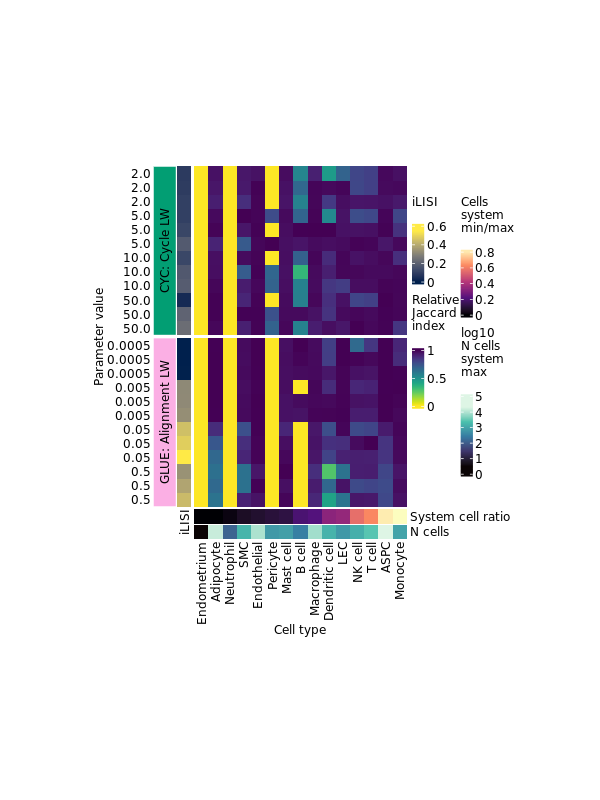

In [54]:
%%R  -w 600 -h 800
# Draw out one example
draw(h)

KNN purity heatmaps

In [63]:
# heatmap per dataset
for dataset,dataset_name in dataset_map.items():
    metric='knn_purity'
    # Dataset data subset
    res=ress.query('dataset_parsed==@dataset_name')
    metrics_data=[metrics_datas[run] for run in res.index]

    # metric data
    dat={}
    for metrics_res in metrics_data:
        dat[metrics_res['name']]=metrics_res[metric]
    dat=pd.DataFrame(dat).T
    # Run order applied to cell metric data and batch score
    run_order=res.sort_values(['model_parsed','param_parsed','param_opt_val','ilisi_system']).index
    dat=dat.loc[run_order,:]
    batch_score=res.loc[run_order,'ilisi_system']
    params_opt=res.loc[run_order,'params_opt']
    params_opt_parsed=dat.index.map(
        lambda x:  f"{res.at[x,'model_parsed']}: {res.at[x,'param_parsed']}")
    params_opt_colors=[model_cmap[i.split(':')[0]] for i in list(dict.fromkeys(params_opt_parsed))]
    run_names=dat.index.map(lambda x: res.at[x,'param_opt_val_str'])
    # Max scale metric data by ct
    dat=dat/np.clip(dat.max(axis=0),a_min=1e-3, a_max=None)

    # Cell type prportions and max N cells per system
    ct_prop=ct_counts[dataset_map_rev[dataset_name]].groupby('group')['n_cells'].apply(
                lambda x: x.min()/x.max())
    ct_max=np.log10(ct_counts[dataset_map_rev[dataset_name]].groupby('group')['n_cells'].max())
    # Sort cell types by cell proportion and then max
    ct_order=pd.concat([ct_prop.rename('prop'),ct_max.rename('max')],axis=1
                      ).sort_values(['prop','max']).index
    ct_prop=ct_prop.loc[ct_order]
    ct_max=ct_max.loc[ct_order]
    dat=dat.loc[:,ct_prop.index]
    # Now replace cell types after matching has ben done on non-parsed cell type names
    dat.rename(cell_type_map[dataset],axis=1,inplace=True)


    # Add data to R
    ro.globalenv['x']=dat
    ro.globalenv['rownames']=list(run_names)
    ro.globalenv['row_blocks']=list(params_opt)
    ro.globalenv['row_blocks_order']=list(dict.fromkeys(params_opt))
    ro.globalenv['row_blocks_parsed_order']=list(dict.fromkeys(params_opt_parsed))
    ro.globalenv['row_blocks_colors']=params_opt_colors
    ro.globalenv['batch_score']=list(batch_score)
    ro.globalenv['ct_prop']=list(ct_prop)
    ro.globalenv['ct_max']=list(ct_max)
    batch_score_name=metric_map['ilisi_system']
    ro.globalenv['batch_score_name']=batch_score_name
    ct_prop_name='Cells\nsystem\nmin/max'
    ro.globalenv['ct_prop_name']=ct_prop_name
    ct_max_name='log10\nN cells\nsystem\nmax'
    ro.globalenv['ct_max_name']=ct_max_name
    ro.globalenv['fig_fn']=path_fig+f'adversarial_ctmix-knn_purity_{dataset}-heatmap.pdf'


    r_command=f"""
    # Process data for R
    rownames<-unlist(rownames)
    row_blocks<-unlist(row_blocks)
    row_blocks_order<-unlist(row_blocks_order)
    row_blocks_parsed_order<-unlist(row_blocks_parsed_order)
    row_blocks_colors<-unlist(row_blocks_colors)
    batch_score<-unlist(batch_score)
    ct_prop<-as.vector(unlist(ct_prop))
    ct_max<-as.vector(unlist(ct_max))
    batch_score_name<-unlist(batch_score_name)[1]

    # Param opt rowsplit and batch score anno
    row_anno = rowAnnotation(
        params_opt = anno_block(
            gp = gpar(fill = row_blocks_colors, col='white'),
            labels = row_blocks_parsed_order, 
            labels_gp = gpar(col = "black", fontsize=12)
        ),
        {batch_score_name}=batch_score,
        annotation_legend_param =list(
            {batch_score_name}=list(
                title=paste0(batch_score_name,'\n'),
                title_gp=gpar(fontsize=12),
                labels_gp=gpar(fontsize=12)
            )
        ),
        col = list(
            {batch_score_name} = colorRamp2(
                seq(min(batch_score), max(batch_score), 
                by = (max(batch_score)-min(batch_score))/4), 
                cividis(5))
        ),
        annotation_name_gp = gpar(fontsize=12),
        annotation_height = list(
            {batch_score_name}=unit(5, "mm")
        )
    )
    row_splits<-factor(row_blocks,levels =row_blocks_order)
    
    # Cell type anno
    col_anno=columnAnnotation(
        ct_prop=ct_prop,
        ct_max=ct_max,
        col = list(
            ct_max = colorRamp2(
                seq(min(ct_max), max(ct_max), 
                by = (max(ct_max)-min(ct_max))/4), 
                mako(5)),
            ct_prop = colorRamp2(
                seq(min(ct_prop), max(ct_prop), 
                by = (max(ct_prop)-min(ct_prop))/4), 
                magma(5))
        ),
        annotation_legend_param =list(
            ct_prop=list(
                title=paste0(ct_prop_name,'\n'),
                title_gp=gpar(fontsize=12),
                labels_gp=gpar(fontsize=12)
            ),
            ct_max=list(
                title=paste0(ct_max_name,'\n'),
                title_gp=gpar(fontsize=12),
                labels_gp=gpar(fontsize=12)
            )
        ),
        annotation_label=c( "System cell ratio", "N cells"),
        annotation_name_gp = gpar(fontsize=12),
        height = 2*unit(5, "mm"),width=ncol(x)*unit(5,"mm")
    )

    h<-Heatmap(x,col=viridis(256, direction = -1),
           row_labels = rownames,
           cluster_columns = FALSE, cluster_rows = FALSE,
           show_column_names = TRUE, show_row_names = TRUE,
           row_title ="Parameter value",
           bottom_annotation=col_anno,
           left_annotation=row_anno,
           row_split =row_splits,
           column_title = 'Cell type',
           row_names_side = "left",
           column_names_side = "bottom",
           column_title_side="bottom",
           heatmap_legend_param = list( title = "Relative\nKNN\npurity\n", 
                                       title_gp=gpar( fontsize = 12),
                                       labels_gp = gpar( fontsize = 12)
                                       ),
           row_names_gp=gpar(fontsize = 12),  
           column_names_gp=gpar( fontsize = 12), 
           row_title_gp=gpar(fontsize = 12),
           column_title_gp=gpar(fontsize = 12),
           row_gap = unit(1, "mm"),
           width = ncol(x)*unit(5, "mm"),height = nrow(x)*unit(5, "mm"),
           show_row_dend = FALSE, 
           )
    
    # Save
    pdf(file=fig_fn, width=10, height=15)
    draw(h)
    dev.off()

    NULL
    """

    _=ro.r(r_command)

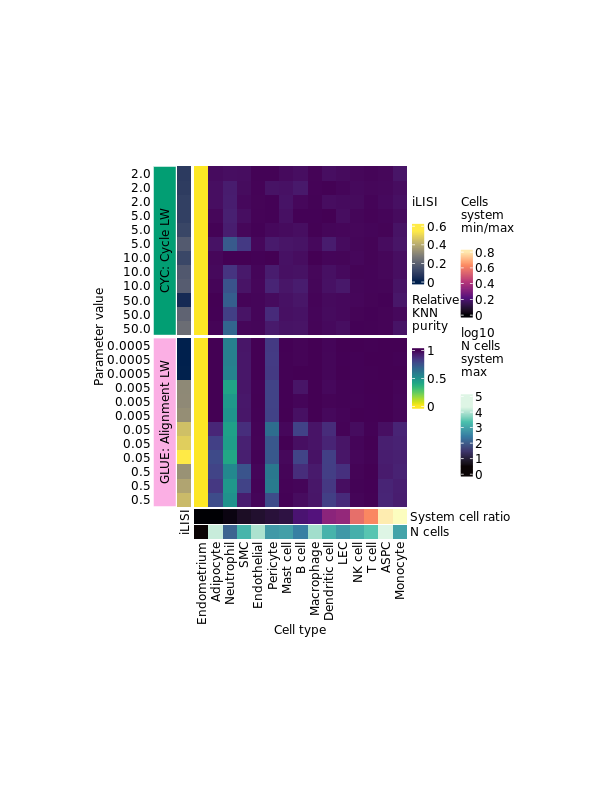

In [64]:
%%R  -w 600 -h 800
# Draw out one example
draw(h)

C: KNN purity better represents local stucture, while Jaccard index is more global. Jaccard distinguished less between integrations of cell types that are generally hard to distinguish (minimal score in either case). Thus more focus is given to populations that have a clear cluster in one case but not the other. Also, small cell populations in generally have less own KNNs and vice versa, which is not accounted by KNN purity. In contrast, Jaccard index is interested in whether a cell type (even a small one) has its own cluster, even if a few escaping cells from other larger cell types are located nearby. Thus Jaccard may be better despite not being local and maybe globality is even better as it is less noisy.